### Regression Total population on distribution of Males across the counties in the US

Ordinarily the bandwidth for the new algo should be very large. 

In [3]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import cenpy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler
from geopandas import GeoDataFrame
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon

import seaborn as sns
sns.set(color_codes=True)

scaler = StandardScaler()
%matplotlib inline


pop_data1 = pd.read_csv('./data/total_pop_mf.csv').drop('geometry', axis=1)

In [4]:
# state_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
#               'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
#               'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
#               'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
#               'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 
#               'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
#               'West Virginia', 'Wisconsin', 'Wyoming'
#              ]

# state_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas']

# def generateDF(variables):
#     x = dict(enumerate(state_list))
#     x.items()
#     for i,j in enumerate(x.items()):
#         x[i] = cenpy.products.Decennial2010().from_state(j[1], level='county', variables=variables)
#     df = pd.concat(list(x.values()))
#     return df 

# pop_data1 = generateDF(['P012002', 'P012026'])
# cenpy.products.Decennial2010().from_state('Maryland', level='county', variables='P012002') #P012026

In [5]:
counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)



empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty]

counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')

pop_data1 = pop_data1.merge(counties_non_empty, left_on='GEOID', right_on='id', how='inner')
pop_data1.drop(['name', 'id'], axis=1, inplace=True)

pop_data1.drop(pop_data1[(pop_data1.GEOID >= 15000) & (pop_data1.GEOID < 16000)].index, inplace=True) # get rid of Hawaii
pop_data1.drop(pop_data1[(pop_data1.GEOID >= 2000) & (pop_data1.GEOID < 4000)].index, inplace=True) # get rid of Hawaii

pop_data1['totalp'] = pop_data1['P012002'] + pop_data1['P012026']
pop_data1 = GeoDataFrame(pop_data1, crs="EPSG:4326")



In [6]:
pop_data1.head()

,GEOID,P012002,P012026,NAME,state,county,geometry,lon,lat,totalp
0,1077,44379.0,48330.0,"Lauderdale County, Alabama",1,77,"POLYGON ((-87.98645 35.00575, -87.60599 35.004...",-87.654681,34.901303,92709.0
1,1105,4980.0,5611.0,"Perry County, Alabama",1,105,"POLYGON ((-87.42293 32.87442, -87.31884 32.875...",-87.294236,32.639178,10591.0
2,1053,19766.0,18553.0,"Escambia County, Alabama",1,53,"POLYGON ((-87.61675 31.24478, -87.55933 31.227...",-87.162772,31.126057,38319.0
3,1089,164320.0,170491.0,"Madison County, Alabama",1,89,"POLYGON ((-86.78404 34.99200, -86.31743 34.991...",-86.550747,34.763769,334811.0
4,1037,5727.0,5812.0,"Coosa County, Alabama",1,37,"POLYGON ((-86.51843 33.02046, -86.51125 33.088...",-86.248270,32.936232,11539.0


### Modelling

In [7]:
g_y = pop_data1["totalp"].values.reshape((-1,1))
g_X = pop_data1[["P012002"]].values

# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

u = pop_data1["lon"]
v = pop_data1["lat"]

g_coords = list(zip(u,v))

In [8]:
%%time
gwr_selector_o = Sel_BW(g_coords, g_y, g_X, lwcc=False)
gwr_bw_o = gwr_selector_o.search(bw_min=None)
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True, lwcc=False).fit()
gwr_results_o.summary()

46.0
Model type                                                         Gaussian
Number of observations:                                                3105
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       81674959679.028
Log-likelihood:                                                  -30930.646
AIC:                                                              61865.292
AICc:                                                             61867.300
BIC:                                                           81674934728.522
R2:                                                                   1.000
Adj. R2:                                                              1.000

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ------

In [9]:
# gwr_results_o.resid_ss

In [10]:
# gwr_results_o.aicc

In [11]:
# gwr_results_o.ENP

### GW Correlation Coefficient. Classic 

In [12]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_y, g_X))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
pop_data1['gwr_calc'] = corr_mat
corr_mat.mean(), corr_mat.min(), corr_mat.max()

(0.9997652426558039, 0.9940907862904872, 0.9999970483692999)

### Calculate GW CC using the new algorithm 

In [13]:
g_y = pop_data1["totalp"].values.reshape((-1,1))
g_X = pop_data1[["P012002"]].values

# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

In [14]:
%%time
gwr_selector_n = Sel_BW(g_coords, g_y, g_X, lwcc=True)
gwr_bw_n = gwr_selector_n.search(bw_min=None)
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit() 
gwr_results_n.summary()

3103.0
Model type                                                         Gaussian
Number of observations:                                                3105
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       81789777358.058
Log-likelihood:                                                  -30932.827
AIC:                                                              61867.654
AICc:                                                             61869.658
BIC:                                                           81789752399.511
R2:                                                                   1.000
Adj. R2:                                                              1.000

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ----

In [15]:
corr = []
# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

for i in range(len(g_X)):
    corr_coef, _ = stats.pearsonr(g_X.flatten(), g_y.flatten())
    corr.append(corr_coef)

np.array(corr).mean()

0.9998666863899554

In [16]:
pop_data1['new_algo_params'] = gwr_results_n.params

In [17]:
# mapp(newgdf, 'new_algo_params','Reds','filename',normal=False, title=None)

In [18]:
# from utils import compare_surfaces

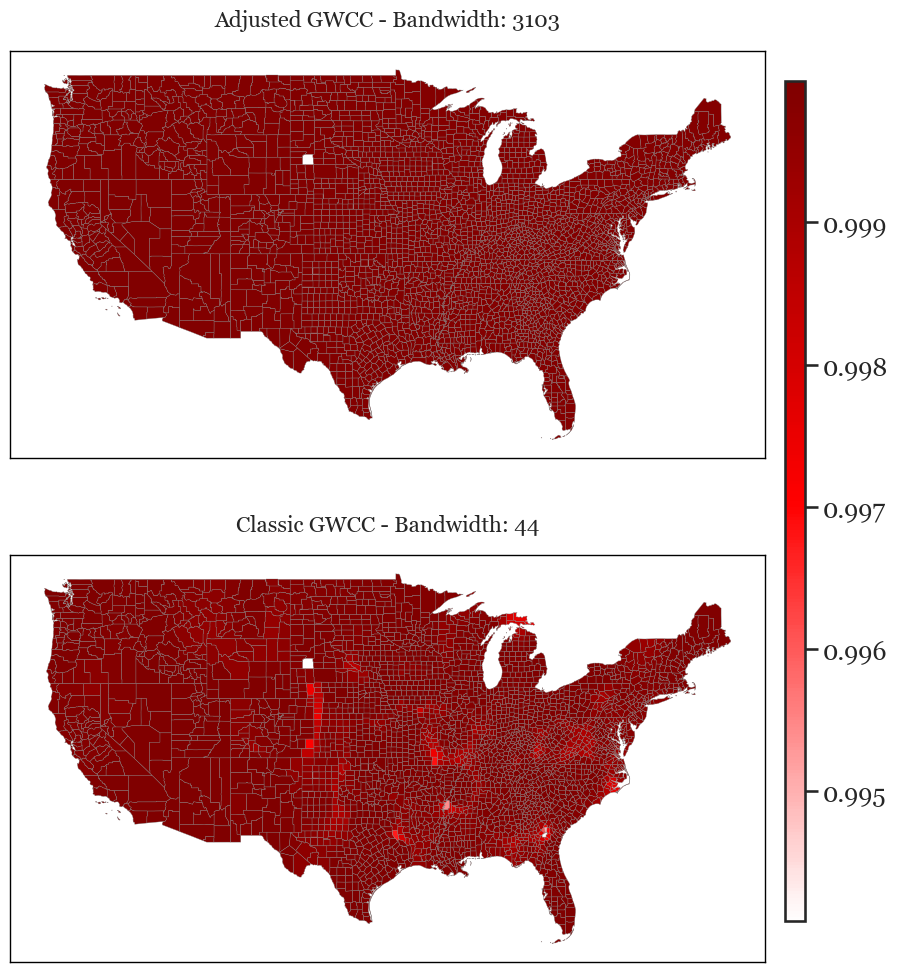

In [19]:
compare_surfaces(pop_data1, 'new_algo_params', 'gwr_calc', savefig='./figs/use-case 1-2025.png')

In [1]:
def compare_surfaces(data, var1, var2, savefig=None):
    """
    Improved visualization for comparing two coefficient surfaces with Georgia-serif titles.
    """
    import matplotlib.pyplot as plt
    import geopandas as gp
    import numpy as np
    import seaborn as sns

    # ---------------------------------
    # Apply Seaborn theme with Georgia
    # ---------------------------------
    sns.set_theme(
        style='white',
        context='talk',
        rc={
            'font.family': 'serif',
            'font.serif': ['Georgia'],
            'font.size': 13,
            'axes.titlesize': 16,
        }
    )
    sns.set_palette('bright')

    # ---------------------------------
    # Figure setup
    # ---------------------------------
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
    ax0, ax1 = axes

    ax0.set_title("Adjusted GWCC - Bandwidth: 3103", pad=18)
    ax1.set_title("Classic GWCC - Bandwidth: 44", pad=18)

    # ---------------------------------
    # Colormap selection logic
    # ---------------------------------
    cmap = plt.cm.seismic

    improved_min = data[var1].min()
    improved_max = data[var1].max()
    classic_min = data[var2].min()
    classic_max = data[var2].max()
    vmin = np.min([improved_min, classic_min])
    vmax = np.max([improved_max, classic_max])

    # apply your smart colormap logic
    if (vmin < 0) and (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    elif (vmin > 0) and (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    else:
        cmap = shift_colormap(
            cmap,
            start=0.0,
            midpoint=1 - vmax / (vmax + abs(vmin)),
            stop=1.0
        )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # ---------------------------------
    # Plot surfaces
    # ---------------------------------
    common_kwargs = dict(
        cmap=sm.cmap,
        vmin=vmin,
        vmax=vmax,
        edgecolor='grey',
        linewidth=0.25
    )

    data.plot(var1, ax=ax0, **common_kwargs)
    data.plot(var2, ax=ax1, **common_kwargs)

    # ---------------------------------
    # Aesthetic cleanup
    # ---------------------------------
    for ax in [ax0, ax1]:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_facecolor("white")

        # Clean, thin spines
        for spine in ax.spines.values():
            spine.set_linewidth(1.0)
            spine.set_edgecolor("black")

    # ---------------------------------
    # Colorbar
    # ---------------------------------
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=18)

    # ---------------------------------
    # Output
    # ---------------------------------
    if savefig is not None:
        plt.savefig(savefig, format="tiff", dpi=600, bbox_inches="tight")

    plt.show()


In [2]:
import numpy as np 

def shift_colormap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    Parameters
    ----------
    cmap : The matplotlib colormap to be altered
    start : Offset from lowest point in the colormap's range.
      Defaults to 0.0 (no lower ofset). Should be between
      0.0 and `midpoint`.
    midpoint : The new center of the colormap. Defaults to
      0.5 (no shift). Should be between 0.0 and 1.0. In
      general, this should be  1 - vmax/(vmax + abs(vmin))
      For example if your data range from -15.0 to +5.0 and
      you want the center of the colormap at 0.0, `midpoint`
      should be set to  1 - 5/(5 + 15)) or 0.75
    stop : Offset from highets point in the colormap's range.
      Defaults to 1.0 (no upper ofset). Should be between
      `midpoint` and 1.0.
    
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    cm.unregister_cmap(name=name)
    


    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    new_cmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    
    plt.register_cmap(cmap=new_cmap)

    return new_cmap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    Function to truncate a colormap by selecting a subset of the original colormap's values
    Parameters
    ----------
    cmap : Mmatplotlib colormap to be altered
    minval : Minimum value of the original colormap to include in the truncated colormap
    maxval : Maximum value of the original colormap to include in the truncated colormap
    n : Number of intervals between the min and max values for the gradient of the truncated colormap
          
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''

    import matplotlib as mpl

    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [ ]:
# import scipy as sp

# import matplotlib as mpl
# import matplotlib.pyplot as plt
# class MidpointNormalize(mpl.colors.Normalize):
#     def __init__(self, vmin, vmax, midpoint=0, clip=False):
#         self.midpoint = midpoint
#         mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

#     def __call__(self, value, clip=None):
#         normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
#         normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
#         normalized_mid = 0.5
#         x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
#         return sp.ma.masked_array(sp.interp(value, x, y))




# def mapp(col,name,color,filename,normal=False, title=None):  
#     vmi=min(col[name])
#     vma=max(col[name])
#     figsize=(14,10)
#     colors = 10
#     norm = MidpointNormalize(vmin=vmi, vmax=vma, midpoint=0)
#     colors = 6
#     fig, ax = plt.subplots(1, figsize=(14, 14))

#     if normal==True:
#         col.plot(column=name, ax=ax,cmap=color,figsize=figsize,k=colors, linewidth=0.5,norm=norm)
#     else:
#         col.plot(column=name, ax=ax,cmap=color,figsize=figsize,k=colors, linewidth=0.5)

#     ax.axis("off")

#     Scalebar = ScaleBar(100000,location='lower left') # 1 pixel = 0.2 meter
#     scatter = ax.collections[-1]

#     plt.colorbar(scatter, ax=ax, extend='min',orientation='horizontal',fraction=0.046, pad=0.04)
#     col.boundary.plot(ax=ax,color='grey',alpha=0.2)
    
#     plt.title(title, fontsize='30', color='k')

# #     texts = []
# #     for x, y, lab in zip(label.geometry.x, label.geometry.y):
# #       texts.append(plt.text(x-1500, y-700, lab, fontsize = 8,horizontalalignment='left',verticalalignment='baseline',bbox=dict(facecolor='white', alpha=0.7,linewidth=0.0)))
# #     label.plot(ax=ax,alpha=1,color='black',linewidth=0.4)
    

#     plt.savefig("./images/"+filename)